<a href="https://colab.research.google.com/github/jaeohshin/Diffusion-Models-pytorch/blob/main/Diffusion_Meets_Flow_Matching_Two_Sides_of_the_Same_Coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab contains code for generating figures in the blog post "Diffusion Meets Flow Matching: Two Sides of the Same Coin" (https://diffusionflow.github.io/).

# Sampling

## Sampling paths with different scalings of the schedule

In [1]:
import plotly
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import scipy

import jax
from jax import numpy as jnp


variance_preserving = lambda logsnr, t: ((1 + jnp.exp(-logsnr)) ** -0.5, (1 + jnp.exp(logsnr)) ** -0.5)
subvariance = lambda lognsr, t: (1. - t + 1e-9, t)

def interp_alpha_sigma(interp):
  def alpha_sigma(logsnr, t):
    alpha1, sigma1 = variance_preserving(logsnr, t)
    alpha2, sigma2 = subvariance(logsnr, t)
    alpha = interp * alpha1 + (1. - interp) * alpha2
    sigma = interp * sigma1 + (1. - interp) * sigma2
    return alpha, sigma
  return alpha_sigma

def make_plot(x_mean=0., x_var=0.001, alpha_sigmas=(variance_preserving,), title=""):
  int_steps = 6
  n_rows = len(alpha_sigmas)
  # Create figure with subplots
  fig = go.Figure()
  fig = make_subplots(rows=n_rows, cols=3,
                      specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}],] * n_rows,
                      subplot_titles=['noise', '', 'data'],
                      column_widths=[0.15, 0.7, 0.15],
                      shared_xaxes=False, shared_yaxes=True,
                      horizontal_spacing=0.02, vertical_spacing=0.05)

  ys = jnp.linspace(-3., 3., 100)
  eps_dist = scipy.stats.norm.pdf(ys) / scipy.stats.norm.pdf(0.)
  x_norm = scipy.stats.norm.pdf(0., loc=0., scale=x_var ** 0.5) * 1.5
  x_dist = scipy.stats.norm.pdf(ys, loc=0., scale=x_var ** 0.5) / x_norm


  # Add marginal distributions
  for row in range(1, 1 + n_rows):
    fig.add_trace(go.Scatter(x=eps_dist, y=ys, line=dict(color='black', width=1.), mode='lines', showlegend=False, hoverinfo='skip'), row=row, col=1)
    fig.add_trace(go.Scatter(x=x_dist, y=ys, line=dict(color='black', width=1.), mode='lines', showlegend=False, hoverinfo='skip'), row=row, col=3)


  start_points = jnp.linspace(-2., 2., num=6)

  schedule = lambda t: -2. * (jnp.log(t + 1e-6) - jnp.log(1. + 1e-6 - t))

  for row, alpha_sigma in zip(range(1, 1 + n_rows), alpha_sigmas):
    tts = jnp.linspace(0., 1., num=256)[::-1]
    ts = tts[:-1]
    ss = tts[1:]
    z = start_points
    zs = [start_points]
    for t, s in zip(ts, ss):
      logsnr_t = schedule(t)
      logsnr_s = schedule(s)
      alpha_t, sigma_t = alpha_sigma(logsnr_t, t)
      alpha_s, sigma_s = alpha_sigma(logsnr_s, s)
      beta2_t = (1 + jnp.exp(-logsnr_t - jnp.log(x_var))) ** -1

      pred_x = beta2_t * (z / alpha_t - x_mean) + x_mean
      pred_eps = (z - alpha_t * pred_x) / sigma_t

      z_s = alpha_s * pred_x + sigma_s * pred_eps
      zs.append(z_s)
      z = z_s

    zs = jnp.stack(zs)

    for i in range(zs.shape[1]):
      fig.add_trace(go.Scatter(x=1. - tts, y=zs[:, i], mode='lines', opacity=0.5, line=dict(color='black', width=1.), showlegend=i == 0 and row == 1, name="Ground truth", legendgroup='ground-truth', hoverinfo='skip'), row=row, col=2)

    tts = jnp.linspace(0., 1., num=int_steps)[::-1]
    ts = tts[:-1]
    ss = tts[1:]
    z = start_points
    zs = [start_points]

    z_mean = 0.
    z_var = 1.

    for t, s in zip(ts, ss):
      logsnr_t = schedule(t)
      logsnr_s = schedule(s)
      alpha_t, sigma_t = alpha_sigma(logsnr_t, t)
      alpha_s, sigma_s = alpha_sigma(logsnr_s, s)
      beta2_t = (1 + jnp.exp(-logsnr_t - jnp.log(x_var))) ** -1
      pred_x = beta2_t * (z / alpha_t - x_mean) + x_mean
      pred_eps = (z - alpha_t * pred_x) / sigma_t
      z_s = alpha_s * pred_x + sigma_s * pred_eps

      pred_x = beta2_t * (z_mean / alpha_t - x_mean) + x_mean
      pred_eps = (z_mean - alpha_t * pred_x) / sigma_t
      z_mean = alpha_s * pred_x + sigma_s * pred_eps
      z_var = (alpha_s * beta2_t / alpha_t + sigma_s / sigma_t * (1. - beta2_t)) ** 2. * z_var
      zs.append(z_s)
      z = z_s
    z0_dist = scipy.stats.norm.pdf(ys, loc=z_mean, scale=z_var ** 0.5) / x_norm
    fig.add_trace(go.Scatter(x=z0_dist, y=ys, mode='lines', line=dict(color='#1f77b4', width=2.), showlegend=False, legendgroup='ddim', hoverinfo='skip'), row=row, col=3)

    zs = jnp.stack(zs)

    for i in range(zs.shape[1]):
      fig.add_trace(go.Scatter(x=1. - tts, y=zs[:, i], mode='lines', line=dict(color='#1f77b4', width=2.), showlegend=i == 0 and row == 1, name='6-step DDIM', legendgroup='ddim', hoverinfo='skip'), row=row, col=2)

    tts = jnp.linspace(0., 1., num=int_steps)[::-1]
    ts = tts[:-1]
    ss = tts[1:]
    z = start_points
    zs = [start_points]
    z_mean = 0.
    z_var = 1.

    for t, s in zip(ts, ss):
      logsnr_t = schedule(t)
      logsnr_s = schedule(s)
      (alpha_t, sigma_t), (alpha_dt, sigma_dt) = jax.jvp(lambda t: alpha_sigma(schedule(t), t), (t,), (jnp.ones_like(t),))
      alpha_s, sigma_s = alpha_sigma(logsnr_s, s)
      beta2_t = (1 + jnp.exp(-logsnr_t - jnp.log(x_var))) ** -1
      pred_x = beta2_t * (z / alpha_t - x_mean) + x_mean
      pred_eps = (z - alpha_t * pred_x) / sigma_t
      z_s = z + (alpha_dt * pred_x + sigma_dt * pred_eps) * (s - t)
      pred_x = beta2_t * (z_mean / alpha_t - x_mean) + x_mean
      pred_eps = (z_mean - alpha_t * pred_x) / sigma_t
      z_mean = z_mean + (alpha_dt * pred_x + sigma_dt * pred_eps) * (s - t)
      z_var = (1. + (alpha_dt * beta2_t / alpha_t + sigma_dt / sigma_t * (1. - beta2_t)) * (s - t)) ** 2. * z_var
      zs.append(z_s)
      z = z_s

    zs = jnp.stack(zs)

    z0_dist = scipy.stats.norm.pdf(ys, loc=z_mean, scale=z_var ** 0.5) / x_norm
    # print(z_mean, z_var)
    fig.add_trace(go.Scatter(x=z0_dist, y=ys, mode='lines', line=dict(color='#FF7F0e', width=2.), showlegend=False, legendgroup='euler', hoverinfo='skip'), row=row, col=3)

    for i in range(zs.shape[1]):
      fig.add_trace(go.Scatter(x=1. - tts, y=zs[:, i], mode='lines', line=dict(color='#FF7F0e', width=2.), showlegend=i == 0 and row == 1, name='6-step Euler', legendgroup='euler', hoverinfo='skip'), row=row, col=2)


  # Update layout
  fig.update_layout(
      title=title,
      template='simple_white',
      showlegend=True,
      yaxis=dict(range=[-2.2, 2.2], fixedrange=True),
      yaxis4=dict(range=[-2.2, 2.2], fixedrange=True),
      xaxis1=dict(visible=False, range=[0., 1.]),
      xaxis2=dict(visible=False),
      xaxis3=dict(visible=False, range=[0., 1.]),
      xaxis4=dict(visible=False, range=[0., 1.]),
      xaxis5=dict(visible=False),
      xaxis6=dict(visible=False, range=[0., 1.]),

  )
  return fig
title = 'Sampling paths with different scalings of the schedule'

fig = make_plot(x_mean=0., x_var=0.25, alpha_sigmas=[subvariance], title=title)

x_vars = np.linspace(0., 1., 8)
plots = [make_plot(x_mean=0., x_var=0.25, alpha_sigmas=[interp_alpha_sigma(x_var)], title=title) for x_var in x_vars]


sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Parameterization: ",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

for i, x_var in enumerate(x_vars):
    i = str(i)
    step_dict = {"args": [
        [i],
        {"frame": {"duration": 30, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 30}}
    ],
        "label": '',
        "method": "animate"}
    sliders_dict['steps'].append(step_dict)
sliders_dict['steps'][0]['label'] = 'FM'
sliders_dict['steps'][-1]['label'] = 'VP'

fig.update(frames=[go.Frame(
                        name=str(i),
                        data=plot.data,
                        traces=list(range(len(fig.data)))) # fig.data[1] is updated by each frame
        for i, plot in enumerate(plots)])

fig.update_layout(sliders=[sliders_dict])

fig.show()

## Variance Preserving vs Flow Matching schedules for varying data distribution

In [2]:
title = 'Variance Preserving vs Flow Matching paths for varying data distributions'


x_vars = np.array([0.01, 0.05, 0.1, 0.5, 1.])
fig = make_plot(x_mean=0., x_var=x_vars[0], alpha_sigmas=[variance_preserving, subvariance], title=title)

plots = [make_plot(x_mean=0., x_var=x_var, alpha_sigmas=[variance_preserving, subvariance], title=title) for x_var in x_vars]


sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "data variance: ",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

for i, x_var in enumerate(x_vars):
    i = str(i)
    step_dict = {"args": [
        [i],
        {"frame": {"duration": 30, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 30}}
    ],
        "label": str(x_var),
        "method": "animate"}
    sliders_dict['steps'].append(step_dict)

fig.update(frames=[go.Frame(
                        name=str(i),
                        data=plot.data,
                        traces=list(range(len(fig.data)))) # fig.data[1] is updated by each frame
        for i, plot in enumerate(plots)])

fig.update_layout(sliders=[sliders_dict])
fig.update_layout(
    yaxis1=dict(title="VP Diffusion"),
    yaxis4=dict(title="Flow Matching"),
    height=600,)


fig.show()
print("Straight to a point is not the same as straight between distributions")

Straight to a point is not the same as straight between distributions


# Training

In [3]:
#@title weighting functions

import plotly.graph_objects as go
import numpy as np
from scipy.stats import norm

# Define functions and parameters
lambda_min = -10  # adjust based on your needs
lambda_max = 10   # adjust based on your needs
label_fontsize = 12

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Same weighting functions
w_edm = lambda x: norm.pdf(x, loc=2.4, scale=2.4) * (np.exp(-x) + .5**2)
w_sd3 = lambda x: 1 / np.sqrt(2 * np.pi) * np.exp(- x ** 2 / 8) / (1- sigmoid(-x/2))**2

ws2 = {
    "v-pred and FM": [lambda x: np.exp(-x/2), '#2ca02c'],
    'EDM': [w_edm, '#9467bd'],
    'SD3': [w_sd3, '#e377c2'],
    "sigmoid": [lambda x: 1/(1+np.exp(x)), '#8c564b'],
}

# Create data
xs = np.linspace(lambda_min, lambda_max, 1000)

# Create plotly figure
fig = go.Figure()

# Add traces
for k in ws2:
    ws_scaled = ws2[k][0](xs) / np.max(ws2[k][0](xs))
    fig.add_trace(go.Scatter(
        x=xs,
        y=ws_scaled,
        name=k,
        line=dict(color=ws2[k][1])
    ))

# Update layout
fig.update_layout(
    title='Weighting functions',
    xaxis_title='λ (log SNR)',
    yaxis_title='w(λ) (normalized)',
    xaxis=dict(range=[lambda_min, lambda_max]),
    yaxis=dict(range=[0, 1.1]),
    hovermode='x unified',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

# Show figure
fig.show()

# Diving deeper into samplers

In [4]:
# @title Deterministic sampler vs. stochastic sampler

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML



# Parameters
N_PARTICLES = 50
DT = .3**2
SIGMA = 1
N_STEPS = 2
np.random.seed(43)

# Modified visualization parameters
PARTICLE_COLOR = '#FF6B6B'  # Coral red for particles
ARROW_COLOR = '#FFFFFF'     # Blue for arrows
PARTICLE_ALPHA = 0.9        # Particle visibility
ARROW_ALPHA = 0.9          # Arrow visibility
DENSITY_ALPHA = 0.8       # Background density
DENSITY_CMAP = 'Blues'    # Density colormap

def gaussian_2d(x, y, mu_x, mu_y, sigma):
    return np.exp(-((x - mu_x)**2 + (y - mu_y)**2)/(2*sigma**2))

# Create grid for heatmap
x = np.linspace(-4, 4, 200)
y = np.linspace(-4, 4, 200)
X, Y = np.meshgrid(x, y)

# Generate initial mixture of Gaussians
def get_initial_pdf():
    return (gaussian_2d(X, Y, -1.5, -1.5, 1) + gaussian_2d(X, Y, 1.5, 1.5, 1)) / 2


evolved_sigma = np.sqrt(1 + SIGMA**2 * DT)

# Generate evolved PDF (slightly more diffused)
def get_evolved_pdf():
    # Slightly larger sigma to show diffusion
    return (gaussian_2d(X, Y, -1.5, -1.5, evolved_sigma) +
            gaussian_2d(X, Y, 1.5, 1.5, evolved_sigma)) / 2

# Initialize particles
initial_particles = []
for _ in range(N_PARTICLES):
    if np.random.rand() < 0.5:
        x = np.random.normal(-1.5, 0.5)
        y = np.random.normal(-1.5, 0.5)
    else:
        x = np.random.normal(1.5, 0.5)
        y = np.random.normal(1.5, 0.5)
    initial_particles.append([x, y])
initial_particles = np.array(initial_particles)

def calculate_drift(x, y):
    mu1_x, mu1_y = -1.5, -1.5
    mu2_x, mu2_y = 1.5, 1.5
    sigma = 1

    w1 = gaussian_2d(x, y, mu1_x, mu1_y, sigma)
    w2 = gaussian_2d(x, y, mu2_x, mu2_y, sigma)
    total = w1 + w2

    dx = ((x - mu1_x) * w1 + (x - mu2_x) * w2) / (sigma**2 * total)
    dy = ((y - mu1_y) * w1 + (y - mu2_y) * w2) / (sigma**2 * total)

    return SIGMA**2 * dx, SIGMA**2 * dy



# Initialize particles
particles_drift = initial_particles.copy()
particles_diffusion = initial_particles.copy()

# Calculate updates
drifts = np.array([calculate_drift(x, y) for x, y in particles_drift])

diffusion_dx = SIGMA * np.sqrt(DT) * np.random.randn(N_PARTICLES)
diffusion_dy = SIGMA * np.sqrt(DT) * np.random.randn(N_PARTICLES)

drift_term = np.sqrt(DT)
new_particles_drift = particles_drift + drift_term * drifts
new_particles_diffusion = particles_diffusion + np.column_stack([diffusion_dx, diffusion_dy])

# Get PDFs
initial_pdf = get_initial_pdf()
evolved_pdf = get_evolved_pdf()


# [Previous imports and setup code remains the same]

# Create figure and subplots with tight layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(left=0, right=1, bottom=0.1, top=0.9, wspace=0.05, hspace=0)

# Initial setup of axes
for ax in [ax1, ax2]:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.15, linestyle='--')

ax1.set_title('Drift Update', pad=10, fontsize=16, fontweight='bold')
ax2.set_title('Diffusion Update', pad=10, fontsize=16, fontweight='bold')

# Create initial plots that we'll update
images = []
scatters = []
quivers = []
for ax in [ax1, ax2]:
    im = ax.imshow(initial_pdf, extent=[-4, 4, -4, 4], origin='lower',
                   cmap=DENSITY_CMAP, alpha=DENSITY_ALPHA)
    scatter = ax.scatter([], [], c=PARTICLE_COLOR, alpha=PARTICLE_ALPHA, s=50)
    # Initialize quiver with zero-length arrows at particle positions
    quiver = ax.quiver(particles_drift[:, 0], particles_drift[:, 1],
                      np.zeros(N_PARTICLES), np.zeros(N_PARTICLES),
                      color=ARROW_COLOR, alpha=ARROW_ALPHA,
                      width=0.0045, headwidth=6, headlength=8,
                      scale_units='xy', angles='xy', scale=1)
    images.append(im)
    scatters.append(scatter)
    quivers.append(quiver)

def init():
    return images + scatters + quivers

def update(frame):
    # Update density plots
    Z = initial_pdf if frame == 0 else evolved_pdf
    images[0].set_array(Z)
    images[1].set_array(Z)

    if frame == 0:  # Before update
        ax1.set_title('Before Update', pad=10, fontsize=16, fontweight='bold')
        ax2.set_title('Before Update', pad=10, fontsize=16, fontweight='bold')
        # Update scatter plots
        scatters[0].set_offsets(particles_drift)
        scatters[1].set_offsets(particles_diffusion)
        # Set zero-length arrows
        quivers[0].set_UVC(np.zeros(N_PARTICLES), np.zeros(N_PARTICLES))
        quivers[1].set_UVC(np.zeros(N_PARTICLES), np.zeros(N_PARTICLES))

    else:  # After update
        ax1.set_title('After Reversed DDIM Update', pad=10, fontsize=16, fontweight='bold')
        ax2.set_title('After Diffusion Update', pad=10, fontsize=16, fontweight='bold')
        # Update scatter plots
        scatters[0].set_offsets(new_particles_drift)
        scatters[1].set_offsets(new_particles_diffusion)

        # Update quivers
        quivers[0].set_UVC(drift_term * drifts[:, 0], drift_term * drifts[:, 1])

        diff_dx = new_particles_diffusion[:, 0] - particles_diffusion[:, 0]
        diff_dy = new_particles_diffusion[:, 1] - particles_diffusion[:, 1]
        quivers[1].set_UVC(diff_dx, diff_dy)

    return images + scatters + quivers

plt.close()

# Create animation
anim = animation.FuncAnimation(fig, update, init_func=init, frames=2,
                             interval=2000, blit=True)
display(HTML(anim.to_jshtml()))

# weighting of v-predictions for stochastic and deterministic samplers

In [5]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def ddpm(logsnr_s, logsnr_t):
  r_alpha_st = jnp.exp(logsnr_t - logsnr_s + 0.5 * (
      jax.nn.softplus(-logsnr_t) - jax.nn.softplus(-logsnr_s)))
  alpha_s = jnp.sqrt(jax.nn.sigmoid(logsnr_s))
  one_minus_r = -jnp.expm1(logsnr_t - logsnr_s)  # 1-SNR(t)/SNR(s)
  alpha = jnp.sqrt(jax.nn.sigmoid(logsnr_t))
  sigma = jnp.sqrt(jax.nn.sigmoid(-logsnr_t))
  # x = alpha * z - sigma * v
  # mean = r_alpha_st * z_t + one_minus_r * alpha_s * x
  wz = r_alpha_st
  wx = one_minus_r * alpha_s
  wv = sigma * wx
  wz += wx * alpha
  return wz, wv

def ddim(logsnr_s, logsnr_t):
  alpha_t = jnp.sqrt(jax.nn.sigmoid(logsnr_t))
  sigma_t = jnp.sqrt(jax.nn.sigmoid(-logsnr_t))
  alpha_s = jnp.sqrt(jax.nn.sigmoid(logsnr_s))
  sigma_s = jnp.sqrt(jax.nn.sigmoid(-logsnr_s))
  # z_s = alpha_s * x + (sigma_s / sigma_t) * (z_t - alpha_t * x)
  wz = (sigma_s / sigma_t)
  wx = alpha_s - alpha_t * (sigma_s / sigma_t)
  wv = sigma_t * wx
  wz += wx * alpha_t
  return wz, wv

def ddim_and_diff(logsnr_s, logsnr_t, churn):
  alpha_t = jnp.sqrt(jax.nn.sigmoid(logsnr_t))
  sigma_t = jnp.sqrt(jax.nn.sigmoid(-logsnr_t))
  alpha_s = jnp.sqrt(jax.nn.sigmoid(logsnr_s))

  logsnr_delta = (logsnr_s - logsnr_t) / (1. - churn)
  logsnr_o = logsnr_t + logsnr_delta
  alpha_o = jnp.sqrt(jax.nn.sigmoid(logsnr_o))
  sigma_o = jnp.sqrt(jax.nn.sigmoid(-logsnr_o))

  # ddim
  # z_o = alpha_o * x + (sigma_o / sigma_t) * (z_t - alpha_t * x)
  wz = (sigma_o / sigma_t)
  wx = alpha_o - alpha_t * (sigma_o / sigma_t)

  # diffuse
  # z_s = (alpha_s / alpha_o) * z_o + sigma_so * noise
  alpha_so = alpha_s / alpha_o
  wz *= alpha_so
  wx *= alpha_so

  wv = sigma_t * wx
  wz += wx * alpha_t
  return wz, wv

def schedule(t, logsnr_min=-20., logsnr_max=20.):
  # -2log(tan(b)) == logsnr_max => b == arctan(exp(-0.5*logsnr_max))
  # -2log(tan(pi/2*a + b)) == logsnr_min
  #     => a == (arctan(exp(-0.5*logsnr_min))-b)*2/pi
  b = np.arctan(np.exp(-0.5 * logsnr_max))
  a = np.arctan(np.exp(-0.5 * logsnr_min)) - b
  return -2. * jnp.log(jnp.tan(a * t + b))

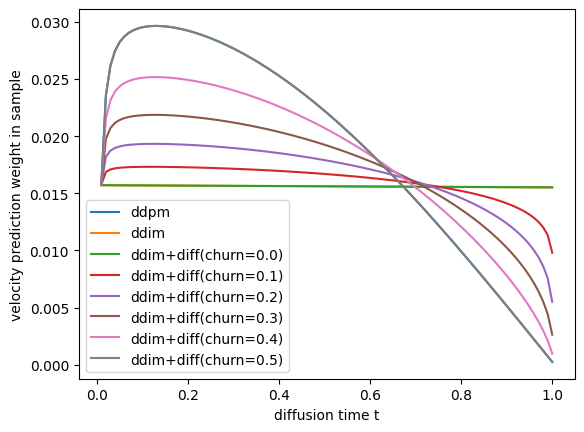

In [6]:
num_steps = 100
w_ddpm = []
w_ddim = []
churn_levels = [c for c in np.arange(0, 0.6, 0.1)]
w_churn = [[] for _ in churn_levels]
t = [1. - (1./num_steps) * i for i in range(num_steps)]
for ti in t:
  logsnr_t = schedule(ti)
  logsnr_s = schedule(ti - 1./num_steps)
  wz, wv = ddpm(logsnr_s, logsnr_t)
  w_ddpm = [wi * wz for wi in w_ddpm]
  w_ddpm.append(wv)
  wz, wv = ddim(logsnr_s, logsnr_t)
  w_ddim = [wi * wz for wi in w_ddim]
  w_ddim.append(wv)
  for i, c in enumerate(churn_levels):
    wz, wv = ddim_and_diff(logsnr_s, logsnr_t, c)
    w_churn[i] = [wi * wz for wi in w_churn[i]]
    w_churn[i].append(wv)

plt.plot(t, w_ddpm, label='ddpm')
plt.plot(t, w_ddim, label='ddim')
for i, c in enumerate(churn_levels):
  plt.plot(t, w_churn[i], label='ddim+diff(churn={0:.1f})'.format(c))
plt.xlabel('diffusion time t')
plt.ylabel('velocity prediction weight in sample')
plt.legend()

In [7]:
# Create plotly figure
fig = go.Figure()

for i, c in enumerate(churn_levels):
  fig.add_trace(
      go.Scatter(
          visible=False,
          line=dict(color="orange", width=4),
          name=f"churn={c}",
          x=t,
          y=w_churn[i]))
fig.data[-1].visible = True

steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
    )
    step["args"][0]["visible"][i] = True
    if i == 0:
      step["label"] = "DDIM (churn=0)"
    elif i == len(fig.data)-1:
      step["label"] = "DDPM (churn=0.5)"
    else:
      step["label"] = "churn={0:.1f}".format(churn_levels[i])
    steps.append(step)

sliders = [dict(
    active=len(fig.data)-1,
    currentvalue={"visible": False},
    pad={"t": 50},
    steps=steps,
    len=0.95,
    x=0.025,
    font=dict(size=12),
)]

fig.update_layout(
    width=850,
    xaxis=dict(title=dict(text="diffusion time", font=dict(size=18, family="Arial", color="black"))),
    yaxis=dict(title=dict(text="velocity prediction weight in final sample", font=dict(size=18, family="Arial", color="black")), range=[0, 0.03]),
    title=dict(text="Effect of sampler churn on the weighting of predictions made during sampling", font=dict(size=20, family="Arial", color="black"), x=0, y=0.9, yref='container', xref='paper'),
    sliders=sliders,
)

fig.show()

*If you find this colab helpful and would like to cite this post in an academic context, you can use this BibTeX snippet:*

```
@inproceedings{gao2025diffusionmeetsflow,
  author = {Gao, Ruiqi and Hoogeboom, Emiel and Heek, Jonathan and Bortoli, Valentin De and Murphy, Kevin P. and Salimans, Tim},
  title = {Diffusion Meets Flow Matching: Two Sides of the Same Coin},
  year = {2024},
  url  = {https://diffusionflow.github.io/}
}
```